# Code to generate a wing
For analysis in OpenVSP from data from FreeCAD lists

In [1]:
import openvsp as vsp
import time
import scipy
import os
import shutil
import csv
import numpy as np
import plotly.express as px

stdout = vsp.cvar.cstdout
errorMgr = vsp.ErrorMgrSingleton.getInstance()
vsp.GetVSPVersion()

'OpenVSP 3.36.0'

### Copy and paste in the lists from FreeCAD Configurations spreadsheet into cell below 

In [ ]:
#xbow
secs = [0.0, 466.332825, 1068.950317, 1646.419556, 2378.06543, 3219.933594, 4135.516602, 4976.60791]
chordsmm = [1962.66687, 1987.5196448199817, 1954.2146835069336, 1914.7599173085641, 1763.9884108574179, 1490.938533817437, 1016.192994, 352.2518309999998]
sweeps = [-4.537751282006804, 7.075437015157452, 17.354512297897873, 23.87103007026493, 26.6878527794197, 29.13589744703327, 33.00663692976908]
dihedrals = [8.5,5.5,1.5,-1,-3,-3,-2]
twists = [-0.7,-1,-2,-4,-6,-8,-9,-10]
ds = [985.511414, 1107.3873208199816, 1207.6250845069337, 1176.541655308564, 1064.9273758574177, 941.416560817437, 696.619263, 352.2518309999998]

In [2]:
#PE13
secs= [0,603.875,1207.75,1811.625,2415.5,3019.375,3623.25,4227.125,4831]
chordsmm = [1855, 1746, 1700, 1647, 1568, 1453, 1272, 947,486]
sweeps = [23.03,23.09,23.57,24.5,25.7,27.82,31.22,31.86]
dihedrals = [0.05,-1.99,-1.99,-2.18,-2.41,-0.57,4.13,4.13]
twists = [0, -3.62, -6.78, -8.9, -11.1, -14.8, -18, -20, -20]
ds = [1714, 1595, 1515, 1459, 1383, 1282, 1099, 824, 473]


In [3]:
spans = []
chords =[]
dSurfs =[]

for i in range(1,len(secs)):
    spans.append((secs[i]-secs[i-1])/1000)

for i in range(len(chordsmm)):
    chords.append(chordsmm[i]/1000)
    dSurfs.append(ds[i]/chordsmm[i])

root_file = 'data/aerofoils/ui1720reflex.csv'
mid_file = 'data/aerofoils/ui1720mod.csv'
outb_file = 'data/aerofoils/2R15section.csv'
tip_file = 'data/aerofoils/tipsection.csv'
rootpts = np.loadtxt(root_file,delimiter = ',')
midpts = np.loadtxt(mid_file,delimiter = ',')
outbpts = np.loadtxt(outb_file,delimiter = ',')
tippts = np.loadtxt(tip_file,delimiter = ',')
secpts = [rootpts,midpts,outbpts,tippts]
rs = [0,0.5,0.75,1]

In [4]:
def interpolate_section(r,secpts,rs):
	assert len(secpts) == len(rs), 'Must a position for every section'
	for pts in secpts:
		assert len(pts) == len(secpts[0]), 'sections must contain same number of points'
	OPpts = []
	for i in range(len(secpts[0])):
		ys = []
		for j in range(len(secpts)):
			assert secpts[j][i][0] == secpts[0][i][0], 'sections must have matching x ordinates'
			ys.append(secpts[j][i][1])
		y = np.interp(r, rs, ys)
		OPpts.append((secpts[0][i][0], y))
	return OPpts

def OPdatFile(pts, fname):
    upperpts = []
    lowerpts = []
    for i in range(len(pts)):
        if pts[i][0]<pts[i-1][0]:
            upperpts.insert(0,list(pts[i]))
        else:
            lowerpts.append(list(pts[i]))
    
    with open(fname,'w') as f:
        f.write('AF'+fname+' \n')
        f.write(str(len(upperpts))+' '+str(len(lowerpts))+'\n \n')
        for pt in upperpts:
            f.write(str(pt[0])+' '+str(pt[1])+'\n')
        for pt in lowerpts:
            f.write(str(pt[0])+' '+str(pt[1])+'\n')

def convertDS(pts,ds, seam,tol=0.01):
    l=len(pts)
    aerof=[]
    dsp = [ds,0]
    dsfp = [seam,0]
    found = False
    front = False
    pl = pts[0]
    highlight=False
    sSurfpts =[]
	
    for p in pts:
        if ds >= 1: #What to do if 100% double surface
            return pts
        elif p[0] < ds and not found:
            dsp[1] = p[1] + ((ds-p[0])*(pl[1]-p[1]))/(pl[0]-p[0])
            found = True
            #print(dsp)
        if not found:
            sSurfpts.insert(0,(p[0],p[1]-tol))
            
        if not highlight and p[0]>pl[0]:
            highlight = True
            #print('found highlight',pl)
        
        if highlight and p[0] > seam:
            dsfp[1]= p[1] + ((seam-p[0])*(pl[1]-p[1]))/(pl[0]-p[0])
            #print('foundseam',p[0])
            
            if p[0]<dsp[0]:
                y = np.interp(p[0],[dsfp[0],dsp[0]],[dsfp[1],dsp[1]])
                aerof.append((p[0],y)) 
            else:
                return aerof + sSurfpts
  
        else:
            aerof.append((p[0],p[1]))
        pl = p
    return aerof

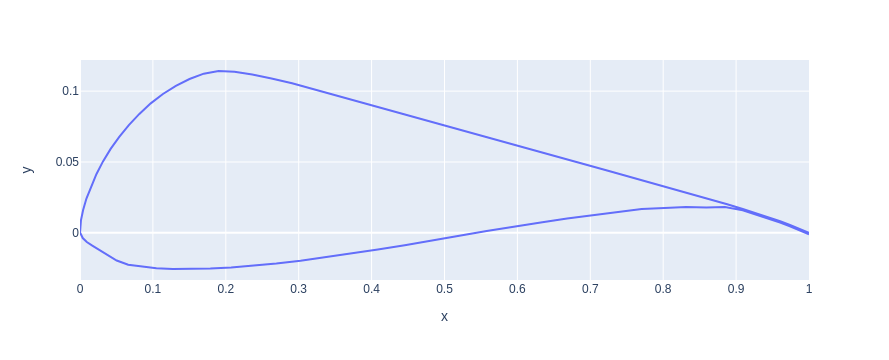

In [5]:
sec=interpolate_section(0.5, secpts, rs)
sec = convertDS(sec,0.9, 0.1/chordsmm[0], 0.001)
xs = [pt[0]  for pt in sec]
ys = [pt[1]  for pt in sec]
fig = px.line(x=xs, y=ys)
fig.show()

### Use this cell to generate a OpenVSP file

In [7]:
path = os.getcwd()+'/'
AFfolder = 'data/aerofoils/TEMP/'
for i in range(len(secs)):
    pts=interpolate_section(secs[i], secpts, rs)
    pts = convertDS(pts,dSurfs[i], 0.1/chordsmm[0], 0.001)
    OPdatFile(pts, path+AFfolder+str(i)+'.dat')

In [8]:
path = os.getcwd()+'/'
fname = 'blank.vsp3'
folder = 'examples/'
AFfolder = 'data/aerofoils/TEMP/'
vsp.VSPRenew()
vsp.ReadVSPFile((path+folder+fname))

for i in range(len(secs)):
    pts=interpolate_section(secs[i]/secs[-1], secpts, rs)
    pts = convertDS(pts,dSurfs[i], 0.1/chordsmm[0], 0.001)
    OPdatFile(pts, path+AFfolder+str(i)+'.dat')

wid = vsp.AddGeom( "WING", "" )
vsp.SetGeomName( wid, "FreeCAD wing")

for i in range(len(spans)):
    vsp.InsertXSec( wid, 1, vsp.XS_FILE_AIRFOIL)
    vsp.Update()



vsp.CutXSec(wid, 1)
xsec_surf = vsp.GetXSecSurf(wid, 0 )
vsp.ChangeXSecShape(xsec_surf, 0, vsp.XS_FILE_AIRFOIL) # Change root section to AF file
xsec = vsp.GetXSec(xsec_surf, 0)
AFname = path+AFfolder+str(0)+'.dat'
vsp.ReadFileAirfoil(xsec, AFname)
vsp.Update()

vsp.SetDriverGroup( wid, 1, 1, 5, 6)

xsec = vsp.GetXSec(xsec_surf, i)
xsecstr = "XSec_0"
vsp.SetParmVal(wid, "Twist",  xsecstr, twists[0]) # Set root incidence

for i in range(len(spans)):
    xsec = vsp.GetXSec(xsec_surf, i)
    AFname = path+AFfolder+str(i+1)+'.dat'
    vsp.ReadFileAirfoil(xsec, AFname)
    xsecstr = "XSec_"+ str(i+1)
    vsp.SetParmVal(wid, "Root_Chord", xsecstr, chords[i])
    vsp.SetParmVal(wid, "Sweep", xsecstr, sweeps[i])
    vsp.SetParmVal(wid, "Sweep_Location", xsecstr, 0)
    vsp.SetParmVal(wid, "Span",  xsecstr, spans[i])
    vsp.SetParmVal(wid, "Dihedral",  xsecstr, dihedrals[i])
    vsp.SetParmVal(wid, "Twist",  xsecstr, twists[i+1])
    vsp.SetParmVal(wid, "Twist_Location",  xsecstr, 0)
    if i == len(spans)-1:
        vsp.SetParmVal( wid, "Tip_Chord", xsecstr, chords[-1])
        xsec = vsp.GetXSec(xsec_surf, i+1)
        vsp.ReadFileAirfoil(xsec, AFname)
    vsp.Update()
S = vsp.GetParmVal( wid, "TotalArea", "WingGeom")
print('Wing generated with', len(spans), 'points', 'Area = ',S)


fnamenew = 'FCwing.vsp3'
vsp.WriteVSPFile(path+folder+fnamenew)


Wing generated with 8 points Area =  13.893352125


### Use this cell to read an OpenVSP file to get the lists to paste back into FreeCAD

In [30]:
vsp.VSPRenew()
fnamenew = 'FCwing.vsp3'
vsp.ReadVSPFile((path+folder+fnamenew))
wid = vsp.FindGeoms()[0]

newSecs, newChords, newDihedrals, newSweeps = [0],[],[],[]
newTwists = [vsp.GetParmVal(wid, "Twist",  'XSec_0')]

for i in range(len(spans)):
    xsec = vsp.GetXSec(xsec_surf, i)
    xsecstr = "XSec_"+ str(i+1)
    newChords.append(vsp.GetParmVal(wid, "Root_Chord", xsecstr)*1000)
    newSweeps.append(vsp.GetParmVal(wid, "Sweep", xsecstr))
    s = vsp.GetParmVal(wid, "Span",  xsecstr)
    newSecs.append(newSecs[-1] + s*1000)
    newDihedrals.append(vsp.GetParmVal(wid, "Dihedral",  xsecstr))
    newTwists.append(vsp.GetParmVal(wid, "Twist",  xsecstr))
    if i == len(spans)-1:
        newChords.append(vsp.GetParmVal( wid, "Tip_Chord", xsecstr)*1000)


print('secs = ', newSecs)
print('chords = ', newChords)
print('sweeps = ', newSweeps)
print('dihedrals =', newDihedrals)
print('twists = ', newTwists)

secs =  [0, 466.332825, 1068.950317, 1646.419556, 2378.06543, 3219.933594, 4135.516602, 4976.60791]
chords =  [1962.6668700000002, 1987.5196448199817, 1954.2146835069332, 1914.7599173085648, 1763.9884108574176, 1490.9385338174372, 1016.1929940000001, 352.2518309999998]
sweeps =  [-4.537751282006804, 7.075437015157452, 17.354512297897873, 23.87103007026493, 26.6878527794197, 29.13589744703327, 33.00663692976908]
dihedrals = [8.5, 5.5, 1.5, -1.0, -3.0, -3.0, -2.0]
twists =  [-0.7, -1.0, -2.0, -4.0, -6.0, -8.0, -9.0, -10.0]
